#### _Working SSAST Implementation_

##### _libraries_

In [1]:
# 2. Install Audio Libraries (Linux System + Python)
!apt-get update -qq && apt-get install -y libsndfile1 ffmpeg > /dev/null
!pip install timm==0.4.5 torchaudio soundfile pandas matplotlib > /dev/null

print(" Environment Ready.")

E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


##### _audio check_

In [2]:
# Cell 2: Transfer Data for Speed
from pathlib import Path

# --- CONFIGURATION: EDIT THIS PATH ---
# Where did you put your files in Drive?
DRIVE_PROJECT_PATH = "SSAST-Project"
# -------------------------------------

In [3]:
# Cell: Data Integrity Check
import pandas as pd
import soundfile as sf
import os
from tqdm import tqdm
csv_path = "metadata/train.csv"
def check_data_health(csv_path):
    print(f"🩺 Checking health of dataset: {csv_path}")

    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"Error: Could not find {csv_path}")
        return

    bad_files = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        file_path = row['filepath']

        # 1. Check if file exists
        if not os.path.exists(file_path):
            bad_files.append((file_path, "File Not Found"))
            continue

        # 2. Check if file is empty
        if os.path.getsize(file_path) < 100: # WAV header is ~44 bytes
            bad_files.append((file_path, "File Empty (<100 bytes)"))
            continue

        # 3. Try to read audio
        try:
            sf.read(file_path)
        except Exception as e:
            # We catch the generic exception because soundfile might crash printing the specific one
            bad_files.append((file_path, "Corrupt Audio Header/Data"))

    if len(bad_files) == 0:
        print("\nDataset is HEALTHY! No corrupt files found.")
    else:
        print(f"\n FOUND {len(bad_files)} BAD FILES!")
        print("Here are the first 5 culprits:")
        for path, reason in bad_files[:21]:
            print(f"  - {path} : {reason}")

        print("\n RECOMMENDATION: Delete these files from your 'data' folder and remove them from your CSV.")

# Run check on Train and Val
check_data_health("metadata/train.csv")
check_data_health("metadata/val.csv")
check_data_health("metadata/test.csv")

🩺 Checking health of dataset: metadata/train.csv


100%|██████████| 2390/2390 [00:31<00:00, 75.80it/s] 



Dataset is HEALTHY! No corrupt files found.
🩺 Checking health of dataset: metadata/val.csv


100%|██████████| 295/295 [00:04<00:00, 65.77it/s]



Dataset is HEALTHY! No corrupt files found.
🩺 Checking health of dataset: metadata/test.csv


100%|██████████| 303/303 [00:04<00:00, 75.38it/s] 


Dataset is HEALTHY! No corrupt files found.


In [ ]:
# Cell: Fix Corrupt CSV Entry
import pandas as pd

csv_path = "metadata/train.csv"
bad_file = "./data/gtzan_10s/reggae/reggae.00088_0.wav"

# Load
df = pd.read_csv(csv_path)
initial_len = len(df)

# Filter out the bad file
df = df[df['filepath'] != bad_file]

# Save back
df.to_csv(csv_path, index=False)

print(f"   Fixed {csv_path}")
print(f"   Removed: {bad_file}")
print(f"   Rows: {initial_len} -> {len(df)}")

##### _dataset loading_

###### dataset 1

In [10]:
# Cell 3: Dataset (With SpecAugment added)
import pandas as pd
import torch
import torchaudio
import soundfile as sf
import os
from torch.utils.data import Dataset, DataLoader

class GTZAN_Metadata_Dataset(Dataset):
    # [CHANGE 1] Add 'augment' parameter (Default is False)
    def __init__(self, csv_path, augment=False):
        self.df = pd.read_csv(csv_path)
        self.augment = augment # Save the flag
        self.target_sr = 16000
        self.target_length = 1024 # frames

        # Mapping from string labels to int
        self.classes = sorted(self.df['label'].unique().tolist())
        self.cls_to_idx = {c: i for i, c in enumerate(self.classes)}

        # SSAST Normalization Stats
        self.norm_mean = -4.2677393
        self.norm_std = 4.5689974

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # FIX PATH logic (Preserved from your code)
        filename = os.path.basename(row['filepath'])
        label_str = row['label']
        genre_folder = label_str

        # Construct the safe local path
        audio_path = f"./data/gtzan_10s/{genre_folder}/{filename}"

        label = self.cls_to_idx[label_str]

        # 1. Load
        audio_np, sr = sf.read(audio_path)
        waveform = torch.from_numpy(audio_np).float()
        if waveform.dim() == 1: waveform = waveform.unsqueeze(0)

        # 2. Resample
        if sr != 16000:
            waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)

        # 3. Spectrogram
        fbank = torchaudio.compliance.kaldi.fbank(
            waveform, htk_compat=True, sample_frequency=16000, use_energy=False,
            window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10
        )

        # [CHANGE 2] Apply SpecAugment ONLY if augment=True
        if self.augment:
            # Mask Frequency (Horizontal stripes) - Mask up to 48 bins
            fbank = torchaudio.transforms.FrequencyMasking(freq_mask_param=48)(fbank.unsqueeze(0)).squeeze(0)
            # Mask Time (Vertical stripes) - Mask up to 192 frames
            fbank = torchaudio.transforms.TimeMasking(time_mask_param=192)(fbank.unsqueeze(0)).squeeze(0)

        # 4. Pad/Crop
        n_frames = fbank.shape[0]
        p = self.target_length - n_frames
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[:self.target_length, :]

        # 5. Normalize
        fbank = (fbank - self.norm_mean) / (self.norm_std * 2)

        return fbank, label

# [CHANGE 3] Enable augmentation for Train, keep False for Val/Test
train_ds = GTZAN_Metadata_Dataset("metadata/train.csv", augment=True)
val_ds   = GTZAN_Metadata_Dataset("metadata/val.csv", augment=False)
test_ds  = GTZAN_Metadata_Dataset("metadata/test.csv", augment=False)

# Create Loaders (Batch sizes kept as 32 as requested)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=8)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=8)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=8)

print(f"Data Ready: {len(train_ds)} Train, {len(val_ds)} Val.")

Data Ready: 2390 Train, 295 Val.


###### dataset 2

In [2]:
# Cell 3: Dataset (Updated: Softer Augmentation)
import pandas as pd
import torch
import torchaudio
import soundfile as sf
import os
from torch.utils.data import Dataset, DataLoader

class GTZAN_Metadata_Dataset(Dataset):
    def __init__(self, csv_path, augment=False):
        self.df = pd.read_csv(csv_path)
        self.augment = augment 
        self.target_sr = 16000 
        self.target_length = 1024 
        
        self.classes = [
            'blues', 'classical', 'country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'
        ]
        self.cls_to_idx = {c: i for i, c in enumerate(self.classes)}
        
        self.norm_mean = -4.2677393
        self.norm_std = 4.5689974

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = os.path.basename(row['filepath']) 
        label_str = row['label']
        genre_folder = label_str 
        
        audio_path = f"./data/gtzan_10s/{genre_folder}/{filename}"
        label = self.cls_to_idx[label_str]
        
        # 1. Load
        if not os.path.exists(audio_path):
            if os.path.exists(row['filepath']):
                audio_path = row['filepath']
            else:
                raise FileNotFoundError(f"❌ CANNOT FIND FILE: {audio_path}")

        audio_np, sr = sf.read(audio_path)
        waveform = torch.from_numpy(audio_np).float()
        if waveform.dim() == 1: waveform = waveform.unsqueeze(0)

        # 2. Resample
        if sr != 16000:
            waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)

        # 3. Spectrogram
        fbank = torchaudio.compliance.kaldi.fbank(
            waveform, htk_compat=True, sample_frequency=16000, use_energy=False,
            window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10
        )
        
        # 4. Augmentation (SOFTER VERSION)
        # [CHANGED] 48->24, 192->96
        if self.augment:
             fbank = torchaudio.transforms.FrequencyMasking(freq_mask_param=36)(fbank.unsqueeze(0)).squeeze(0)
             fbank = torchaudio.transforms.TimeMasking(time_mask_param=144)(fbank.unsqueeze(0)).squeeze(0)

        # 5. Pad/Crop
        n_frames = fbank.shape[0]
        p = self.target_length - n_frames
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[:self.target_length, :]
            
        # 6. Normalize
        fbank = (fbank - self.norm_mean) / (self.norm_std * 2)
        
        return fbank, label

# Re-Initialize Loaders Immediately to apply changes
train_ds = GTZAN_Metadata_Dataset("metadata/train.csv", augment=True)
val_ds   = GTZAN_Metadata_Dataset("metadata/val.csv", augment=False)
test_ds  = GTZAN_Metadata_Dataset("metadata/test.csv", augment=False)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=8)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=8)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

print("✅ Dataset Updated with Softer Augmentation.")
print(f"Data Ready: {len(train_ds)} Train, {len(val_ds)} Val.")

✅ Dataset Updated with Softer Augmentation.
Data Ready: 2390 Train, 295 Val.


##### _models_ fine tuning

###### SSAST Training

In [ ]:
# Cell 4: SSAST Training (Saves Every Epoch) same as 78.22% accuracy on test above this
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from ast_models import ASTModel
import os
import gc

# --- CONFIGURATION ---
# Use "expandable_segments" to handle memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
WEIGHTS_PATH = "SSAST-Base-Patch-400.pth"
SAVE_DIR = "augment_16_1_8/" # Folder to keep them organized

# Create the folder if it doesn't exist
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Reduced batch size to fit in memory
BATCH_SIZE = 16
# Accumulate gradients to simulate batch size of 32 (8 * 4 = 32)
ACCUM_STEPS = 2
# ---------------------

# 1. Clear Memory first
if 'ssast_model' in globals(): del ssast_model
if 'optimizer' in globals(): del optimizer
torch.cuda.empty_cache()
gc.collect()

# 2. Setup Device & Loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Re-create loaders with smaller batch size
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# 3. Initialize Model
print(f"Initializing SSAST...")
ssast_model = ASTModel(
    label_dim=527, input_fdim=128, input_tdim=1024,
    model_size='base', pretrain_stage=False,
    load_pretrained_mdl_path=WEIGHTS_PATH,
    fshape=16, tshape=16, fstride=10, tstride=10
)

# 4. Modify Head
if hasattr(ssast_model, 'mlp_head'):
    input_dim = ssast_model.mlp_head[1].in_features
    ssast_model.mlp_head[1] = nn.Linear(input_dim, 10)
    print("Modified mlp_head.")
else:
    print("Error finding head. Using fallback.")
    ssast_model.head = nn.Linear(768, 10)

ssast_model = ssast_model.to(device)

# 5. Training Loop
optimizer = optim.Adam(ssast_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler('cuda')

print("Starting Fine-Tuning (Saving Every Epoch)...")

for epoch in range(100):
    ssast_model.train()
    loss_sum = 0
    correct = 0
    total = 0

    optimizer.zero_grad()

    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        # Mixed Precision
        with torch.amp.autocast('cuda'):
            out = ssast_model(x, task='ft_avgtok')
            loss = criterion(out, y)
            loss = loss / ACCUM_STEPS

        scaler.scale(loss).backward()

        if (i + 1) % ACCUM_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        loss_sum += loss.item() * ACCUM_STEPS
        _, preds = out.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()

    # Validation
    ssast_model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            with torch.amp.autocast('cuda'):
                out = ssast_model(x, task='ft_avgtok')
            _, preds = out.max(1)
            val_total += y.size(0)
            val_correct += preds.eq(y).sum().item()

    train_acc = 100 * correct / total
    val_acc = 100 * val_correct / val_total

    # --- NEW SAVING LOGIC ---
    print(f"Epoch {epoch+1} | Loss: {loss_sum/len(train_loader):.4f} | Train: {train_acc:.1f}% | Val: {val_acc:.1f}%")

    # Create unique filename: "epoch1_T99.0_V83.5.pth"
    filename = f"epoch{epoch+1}_T{train_acc:.1f}_V{val_acc:.1f}.pth"
    save_path = os.path.join(SAVE_DIR, filename)

    torch.save(ssast_model.state_dict(), save_path)
    print(f" Saved: {filename}")

print("\n Training Complete.")

###### SSAST Training Optimized

In [ ]:
# Cell 4: SSAST Training (Saves Every Epoch with Custom Name) Optimised above but saves every epoch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from ast_models import ASTModel
import os
import gc

# --- CONFIGURATION ---
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
WEIGHTS_PATH = "SSAST-Base-Patch-400.pth"
# Base folder for saving checkpoints
SAVE_DIR = "checkpoints_optimized_150E_16_2/"

# Create the folder if it doesn't exist
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# STABLE SETTINGS
BATCH_SIZE = 16
ACCUM_STEPS = 2
# ---------------------

# 1. Clear Memory
if 'ssast_model' in globals(): del ssast_model
if 'optimizer' in globals(): del optimizer
torch.cuda.empty_cache()
gc.collect()

# 2. Setup Device & Loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Re-create loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# 3. Initialize Model
print(f"Initializing SSAST...")
ssast_model = ASTModel(
    label_dim=527, input_fdim=128, input_tdim=1024,
    model_size='base', pretrain_stage=False,
    load_pretrained_mdl_path=WEIGHTS_PATH,
    fshape=16, tshape=16, fstride=10, tstride=10
)

# 4. Modify Head
if hasattr(ssast_model, 'mlp_head'):
    input_dim = ssast_model.mlp_head[1].in_features
    ssast_model.mlp_head[1] = nn.Linear(input_dim, 10)
    print(" Modified mlp_head.")
else:
    print(" Error finding head. Using fallback.")
    ssast_model.head = nn.Linear(768, 10)

ssast_model = ssast_model.to(device)

# 5. Tuned Optimizer & Scheduler
optimizer = optim.AdamW(ssast_model.parameters(), lr=1e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)

criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler('cuda')

# Track best just for display
best_val_acc = 0.0

print(" Starting Fine-Tuning (Saving EVERY Epoch)...")

for epoch in range(150):
    ssast_model.train()
    loss_sum = 0
    correct = 0
    total = 0

    optimizer.zero_grad()

    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        # Mixed Precision
        with torch.amp.autocast('cuda'):
            out = ssast_model(x, task='ft_avgtok')
            loss = criterion(out, y)
            loss = loss / ACCUM_STEPS

        scaler.scale(loss).backward()

        if (i + 1) % ACCUM_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        loss_sum += loss.item() * ACCUM_STEPS
        _, preds = out.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()

    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Validation
    ssast_model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            with torch.amp.autocast('cuda'):
                out = ssast_model(x, task='ft_avgtok')
            _, preds = out.max(1)
            val_total += y.size(0)
            val_correct += preds.eq(y).sum().item()

    train_acc = 100 * correct / total
    val_acc = 100 * val_correct / val_total

    # Update Best Record (for display)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        is_best_str = " (New Best)"
    else:
        is_best_str = ""

    # --- SAVE EVERY EPOCH ---
    # Construct filename: ssast_model_epoch1_accT99.5accval83.2_optimized.pth
    filename = f"ssast_model_epoch{epoch+1}_accT{train_acc:.1f}accval{val_acc:.1f}_optimized.pth"
    full_save_path = os.path.join(SAVE_DIR, filename)

    torch.save(ssast_model.state_dict(), full_save_path)

    # Print status
    print(f"Epoch {epoch+1} | Loss: {loss_sum/len(train_loader):.4f} | LR: {current_lr:.2e} | Train: {train_acc:.1f}% | Val: {val_acc:.1f}% {is_best_str}")
    print(f"    💾 Saved: {filename}")

print("\n Training Complete.")

###### SSAST Training Optimized + LLRD + Label Smoothing

In [3]:
# Cell 4: SSAST Training (Scenario B: LLRD + 150 Epochs - Save > 84%)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from ast_models import ASTModel
import os
import gc

# --- CONFIGURATION ---
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
WEIGHTS_PATH = "SSAST-Base-Patch-400.pth"

# [CHANGED] New folder so we don't overwrite your 80% model
SAVE_DIR = "checkpoints_LLRD_150E_softned/" 

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# SETTINGS
BATCH_SIZE = 16
ACCUM_STEPS = 2
# [CHANGED] Increased epochs to give the slow learning rate time to work
NUM_EPOCHS = 170  
# ---------------------

# 1. Clear Memory
if 'ssast_model' in globals(): del ssast_model
if 'optimizer' in globals(): del optimizer
torch.cuda.empty_cache()
gc.collect()

# 2. Setup Device & Loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# 3. Initialize Model
print(f"Initializing SSAST...")
ssast_model = ASTModel(
    label_dim=527, input_fdim=128, input_tdim=1024,
    model_size='base', pretrain_stage=False,
    load_pretrained_mdl_path=WEIGHTS_PATH,
    fshape=16, tshape=16, fstride=10, tstride=10
)

# 4. Modify Head
if hasattr(ssast_model, 'mlp_head'):
    input_dim = ssast_model.mlp_head[1].in_features
    ssast_model.mlp_head[1] = nn.Linear(input_dim, 10)
else:
    ssast_model.head = nn.Linear(768, 10)

ssast_model = ssast_model.to(device)

# ==============================================================================
# [NEW] LAYER-WISE LEARNING RATE DECAY (LLRD) SETUP
# ==============================================================================
# Logic: We separate the model into two parts:
# 1. The "Head" (New Classifier) -> Needs High LR (1e-4) to learn fast
# 2. The "Backbone" (Pretrained AudioSet) -> Needs Low LR (5e-6) to not forget

head_params = []
backbone_params = []
# These are the standard names for the classification layer in AST
head_names = ['mlp_head', 'head'] 

for name, param in ssast_model.named_parameters():
    if any(h in name for h in head_names):
        head_params.append(param)
    else:
        backbone_params.append(param)

# [CHANGED] Optimizer now takes a LIST of groups instead of model.parameters()
optimizer = optim.AdamW([
    {'params': backbone_params, 'lr': 5e-6}, # Very slow learning for the body
    {'params': head_params,     'lr': 1e-4}  # Fast learning for the head
], weight_decay=0.01)

# [CHANGED] Scheduler must match the new NUM_EPOCHS
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# [NEW] Label Smoothing: Prevents the model from being "too confident"
# This helps it generalize better when training for longer.
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# ==============================================================================

scaler = torch.amp.GradScaler('cuda')

# Track best
best_val_acc = 0.0

print(f"Starting Training ({NUM_EPOCHS} Epochs) with LLRD...")
print(f"-> Backbone LR: 5e-6 (Slow)")
print(f"-> Head LR:     1e-4 (Fast)")

for epoch in range(NUM_EPOCHS):
    ssast_model.train()
    loss_sum = 0
    correct = 0
    total = 0

    optimizer.zero_grad()

    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        with torch.amp.autocast('cuda'):
            out = ssast_model(x, task='ft_avgtok')
            loss = criterion(out, y)
            loss = loss / ACCUM_STEPS

        scaler.scale(loss).backward()

        if (i + 1) % ACCUM_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        loss_sum += loss.item() * ACCUM_STEPS
        _, preds = out.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()

    scheduler.step()
    
    # [NEW] Get current LR specifically for the Body (group 0) to print
    current_lr = optimizer.param_groups[0]['lr']

    # Validation
    ssast_model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            with torch.amp.autocast('cuda'):
                out = ssast_model(x, task='ft_avgtok')
            _, preds = out.max(1)
            val_total += y.size(0)
            val_correct += preds.eq(y).sum().item()

    train_acc = 100 * correct / total
    val_acc = 100 * val_correct / val_total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        is_best_str = " (New Best)"
    else:
        is_best_str = ""

    # [MODIFIED] Save ONLY if Validation Accuracy is > 84%
    if val_acc > 84.0:
        filename = f"ssast_epoch{epoch+1}_T{train_acc:.1f}_V{val_acc:.1f}.pth"
        full_save_path = os.path.join(SAVE_DIR, filename)
        torch.save(ssast_model.state_dict(), full_save_path)
        save_msg = f"\n    💾 Saved (Val > 84%): {filename}"
    else:
        save_msg = ""

    print(f"Epoch {epoch+1} | Loss: {loss_sum/len(train_loader):.4f} | LR(Body): {current_lr:.2e} | Train: {train_acc:.1f}% | Val: {val_acc:.1f}% {is_best_str}{save_msg}")

print("\n Training Complete.")

Device: cuda
Initializing SSAST...
now load a SSL pretrained models from SSAST-Base-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=1212
Starting Training (170 Epochs) with LLRD...
-> Backbone LR: 5e-6 (Slow)
-> Head LR:     1e-4 (Fast)
Epoch 1 | Loss: 2.2460 | LR(Body): 5.00e-06 | Train: 18.8% | Val: 28.8%  (New Best)
Epoch 2 | Loss: 1.9446 | LR(Body): 5.00e-06 | Train: 34.2% | Val: 46.4%  (New Best)
Epoch 3 | Loss: 1.7754 | LR(Body): 5.00e-06 | Train: 42.2% | Val: 59.3%  (New Best)
Epoch 4 | Loss: 1.6464 | LR(Body): 4.99e-06 | Train: 48.6% | Val: 62.7%  (New Best)
Epoch 5 | Loss: 1.5872 | LR(Body): 4.99e-06 | Train: 50.7% | Val: 69.2%  (New Best)
Epoch 6 | Loss: 1.4919 | LR(Body): 4.98e-06 | Train: 55.2% | Val: 72.5%  (New Best)
Epoch 7 | Loss: 1.

###### SSAST Training Optimized + LLRD + Label Smoothing + Parallelisme

In [ ]:
# Cell 4: SSAST Training (Scenario B: LLRD + Parallelism + 150 Epochs)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from ast_models import ASTModel
import os
import gc

# --- CONFIGURATION ---
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
WEIGHTS_PATH = "SSAST-Base-Patch-400.pth"

# [CHANGED] New folder so we don't overwrite your 80% model
SAVE_DIR = "checkpoints_LLRD_150E/" 

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# SETTINGS
# [NOTE] If using multiple GPUs, this BATCH_SIZE is the TOTAL across all GPUs.
# E.g., if BATCH_SIZE=16 and you have 2 GPUs, each GPU gets 8 samples.
BATCH_SIZE = 16 
ACCUM_STEPS = 2
NUM_EPOCHS = 170  
# ---------------------

# 1. Clear Memory
if 'ssast_model' in globals(): del ssast_model
if 'optimizer' in globals(): del optimizer
torch.cuda.empty_cache()
gc.collect()

# 2. Setup Device & Loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Loaders
# [NOTE] Num_workers is critical for keeping multi-GPUs fed. 8 is good.
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# 3. Initialize Model
print(f"Initializing SSAST...")
ssast_model = ASTModel(
    label_dim=527, input_fdim=128, input_tdim=1024,
    model_size='base', pretrain_stage=False,
    load_pretrained_mdl_path=WEIGHTS_PATH,
    fshape=16, tshape=16, fstride=10, tstride=10
)

# 4. Modify Head
if hasattr(ssast_model, 'mlp_head'):
    input_dim = ssast_model.mlp_head[1].in_features
    ssast_model.mlp_head[1] = nn.Linear(input_dim, 10)
else:
    ssast_model.head = nn.Linear(768, 10)

ssast_model = ssast_model.to(device)

# ==============================================================================
# [NEW] LAYER-WISE LEARNING RATE DECAY (LLRD) SETUP
# ==============================================================================
head_params = []
backbone_params = []
head_names = ['mlp_head', 'head'] 

# We do this separation BEFORE wrapping in DataParallel to keep names simple
for name, param in ssast_model.named_parameters():
    if any(h in name for h in head_names):
        head_params.append(param)
    else:
        backbone_params.append(param)

optimizer = optim.AdamW([
    {'params': backbone_params, 'lr': 5e-6}, # Slow Body
    {'params': head_params,     'lr': 1e-4}  # Fast Head
], weight_decay=0.01)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
criterion = nn.CrossEntropyLoss(label_smoothing=0.2) # High smoothing for "Medium" Augment

# ==============================================================================
# [NEW] PARALLELISM BLOCK
# ==============================================================================
if torch.cuda.device_count() > 1:
    print(f"🚀 Parallelism Enabled: Using {torch.cuda.device_count()} GPUs!")
    # Wraps the model to split the batch across GPUs automatically
    ssast_model = nn.DataParallel(ssast_model)
else:
    print("ℹ️ Parallelism Skipped: Single GPU detected.")
# ==============================================================================

scaler = torch.amp.GradScaler('cuda')

# Track best
best_val_acc = 0.0

print(f"Starting Training ({NUM_EPOCHS} Epochs) with LLRD...")

for epoch in range(NUM_EPOCHS):
    ssast_model.train()
    loss_sum = 0
    correct = 0
    total = 0

    optimizer.zero_grad()

    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        with torch.amp.autocast('cuda'):
            # DataParallel automatically splits 'x' and runs forward on all GPUs
            out = ssast_model(x, task='ft_avgtok')
            loss = criterion(out, y)
            loss = loss / ACCUM_STEPS

        scaler.scale(loss).backward()

        if (i + 1) % ACCUM_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        loss_sum += loss.item() * ACCUM_STEPS
        _, preds = out.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()

    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Validation
    ssast_model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            with torch.amp.autocast('cuda'):
                out = ssast_model(x, task='ft_avgtok')
            _, preds = out.max(1)
            val_total += y.size(0)
            val_correct += preds.eq(y).sum().item()

    train_acc = 100 * correct / total
    val_acc = 100 * val_correct / val_total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        is_best_str = " (New Best)"
    else:
        is_best_str = ""

    # [CHANGED] Save Logic for Parallel Models
    # If we used DataParallel, the real model is inside .module
    # We unwrap it so you can load it easily later on a CPU or single GPU
    if hasattr(ssast_model, 'module'):
        state_dict = ssast_model.module.state_dict()
    else:
        state_dict = ssast_model.state_dict()

    filename = f"ssast_epoch{epoch+1}_T{train_acc:.1f}_V{val_acc:.1f}.pth"
    full_save_path = os.path.join(SAVE_DIR, filename)
    
    # Save the clean state_dict
    torch.save(state_dict, full_save_path)

    print(f"Epoch {epoch+1} | Loss: {loss_sum/len(train_loader):.4f} | LR(Body): {current_lr:.2e} | Train: {train_acc:.1f}% | Val: {val_acc:.1f}% {is_best_str}")
    print(f"    Saved: {filename}")

print("\n Training Complete.")

##### _testing and voting_

In [6]:
# Cell 6: Final Test Evaluation (CPU/GPU Compatible)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from ast_models import ASTModel
import os

# --- CONFIGURATION ---
BASE_WEIGHTS_PATH = "SSAST-Base-Patch-400.pth"
# Ensure this matches the file you actually want to test!
BEST_MODEL_PATH = "checkpoints_LLRD_150E_softned/ssast_epoch117_T85.9_V85.1.pth"
BATCH_SIZE = 16
# ---------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# 1. Load Test Data
# (Using default dataset class)
test_ds = GTZAN_Metadata_Dataset("metadata/test.csv")
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# 2. Re-Initialize Model Architecture
print(f"Re-building model architecture...")
ssast_model = ASTModel(
    label_dim=527, input_fdim=128, input_tdim=1024,
    model_size='base', pretrain_stage=False,
    load_pretrained_mdl_path=BASE_WEIGHTS_PATH,
    fshape=16, tshape=16, fstride=10, tstride=10
)

# 3. Modify Head
if hasattr(ssast_model, 'mlp_head'):
    input_dim = ssast_model.mlp_head[1].in_features
    ssast_model.mlp_head[1] = nn.Linear(input_dim, 10)
else:
    ssast_model.head = nn.Linear(768, 10)

ssast_model = ssast_model.to(device)

# 4. Load Best Weights (Fixed for CPU)
if os.path.exists(BEST_MODEL_PATH):
    print(f"Loading weights from: {BEST_MODEL_PATH}")
    # [FIX]: Added map_location=device to handle CPU loading
    ssast_model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
else:
    print(f"Warning: {BEST_MODEL_PATH} not found. Using initialized weights.")

# 5. Run Evaluation
print(f"Evaluation on {len(test_ds)} Test Samples...")

ssast_model.eval()
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        # Use Mixed Precision (only works on CUDA, so we disable it for CPU safety)
        if device.type == 'cuda':
            with torch.amp.autocast('cuda'):
                out = ssast_model(x, task='ft_avgtok')
        else:
            # CPU Fallback
            out = ssast_model(x, task='ft_avgtok')

        _, preds = out.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

final_acc = 100 * correct / total
print("-" * 30)
print(f"FINAL TEST ACCURACY: {final_acc:.2f}%")
print("-" * 30)

Device: cuda
Re-building model architecture...
now load a SSL pretrained models from SSAST-Base-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=1212
Loading weights from: checkpoints_LLRD_150E_softned/ssast_epoch117_T85.9_V85.1.pth
Evaluation on 303 Test Samples...
------------------------------
FINAL TEST ACCURACY: 79.54%
------------------------------


In [7]:
# Cell 8 (Update): Hard Voting (Robust Democracy)
import numpy as np
import os
import torch
from collections import Counter

print(f"🗳️ Starting Hard Voting (Counting Votes)...")

ssast_model.eval()
song_votes = {}
song_probs = {}  # Keep probs for tie-breaking
song_truth = {}
processed_clips = 0

BATCH_SIZE = test_loader.batch_size

with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device)
        
        # Get probabilities
        if device.type == 'cuda':
            with torch.amp.autocast('cuda'):
                logits = ssast_model(x, task='ft_avgtok')
                probs = torch.softmax(logits, dim=1)
        else:
            logits = ssast_model(x, task='ft_avgtok')
            probs = torch.softmax(logits, dim=1)
        
        probs = probs.cpu().numpy()
        preds = probs.argmax(axis=1) # Hard predictions
        labels = y.numpy()
        
        # Batch offset
        start_idx = i * BATCH_SIZE 
        
        for j in range(len(labels)):
            global_idx = start_idx + j
            
            row = test_ds.df.iloc[global_idx]
            filename = os.path.basename(row['filepath'])
            
            # Extract Song ID ("blues.00001")
            song_id = filename.rsplit('_', 1)[0] 
            
            if song_id not in song_votes:
                song_votes[song_id] = []
                song_probs[song_id] = []
                song_truth[song_id] = labels[j]
            
            song_votes[song_id].append(preds[j])
            song_probs[song_id].append(probs[j])
            processed_clips += 1

print(f"✅ Processed {processed_clips} clips.")

# Calculate Accuracy with Hard Voting
correct_songs = 0
total_songs = 0

for song_id, votes in song_votes.items():
    # 1. Count the votes (e.g., {0: 2, 1: 1})
    counts = Counter(votes)
    
    # 2. Find the winner
    # most_common(1) returns [(Label, Count)]
    winner, vote_count = counts.most_common(1)[0]
    
    # 3. Handle Ties (1-1-1 split)
    # If the winner has only 1 vote (and there are 3 clips), it's a 3-way tie.
    if vote_count == 1 and len(votes) == 3:
        # Fallback to Soft Voting (Average probabilities)
        avg_score = np.mean(song_probs[song_id], axis=0)
        winner = np.argmax(avg_score)
    
    true_label = song_truth[song_id]
    
    if winner == true_label:
        correct_songs += 1
    total_songs += 1

print("-" * 30)
print(f"🎵 FINAL SONG ACCURACY (Hard Voting): {100 * correct_songs / total_songs:.2f}%")
print("-" * 30)

🗳️ Starting Hard Voting (Counting Votes)...
✅ Processed 303 clips.
------------------------------
🎵 FINAL SONG ACCURACY (Hard Voting): 82.18%
------------------------------


##### _confusion matrix_

📊 Generating Confusion Matrix...


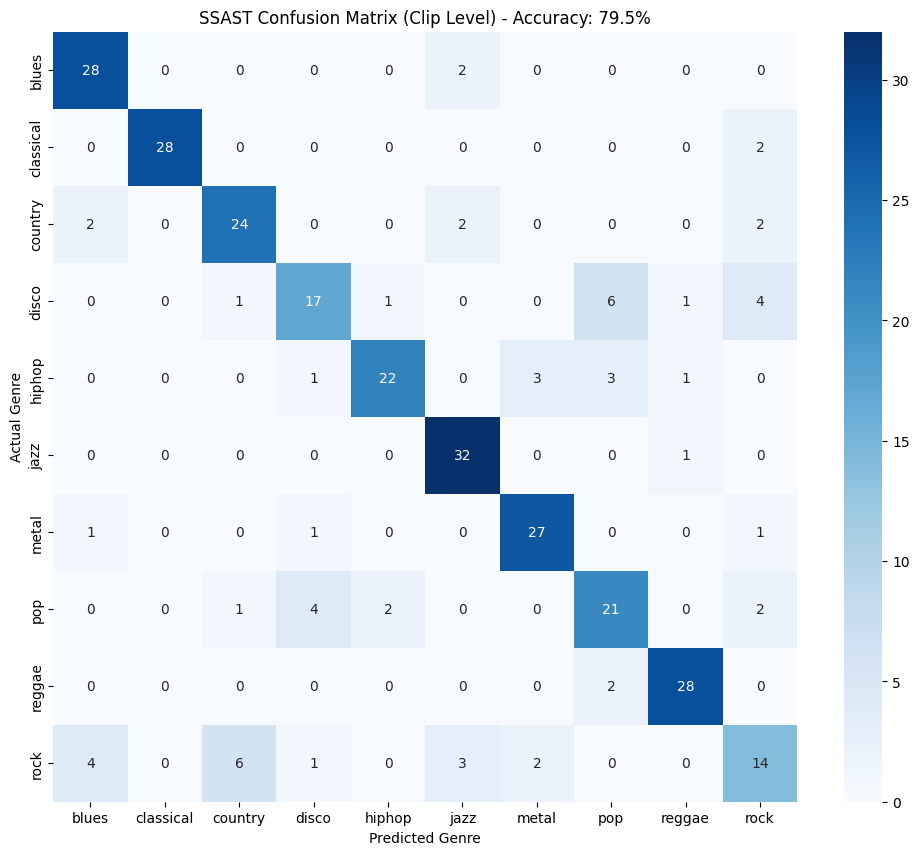

✅ Saved confusion_matrix.png


<Figure size 640x480 with 0 Axes>

In [8]:
# Cell 10: Final Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch
import numpy as np

# 1. Get all predictions
print("📊 Generating Confusion Matrix...")
ssast_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        
        # Inference
        if device.type == 'cuda':
            with torch.amp.autocast('cuda'):
                logits = ssast_model(x, task='ft_avgtok')
        else:
            logits = ssast_model(x, task='ft_avgtok')
            
        _, preds = logits.max(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.numpy())

# 2. Compute Matrix
# Get class names in correct order (0 to 9)
classes = test_ds.classes 
cm = confusion_matrix(all_labels, all_preds)

# 3. Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual Genre')
plt.xlabel('Predicted Genre')
plt.title(f'SSAST Confusion Matrix (Clip Level) - Accuracy: {100*np.mean(np.array(all_preds)==np.array(all_labels)):.1f}%')
plt.show()

# Save it
plt.savefig("confusion_matrix.png")
print("✅ Saved confusion_matrix.png")

📊 Generating Song-Level Confusion Matrix...


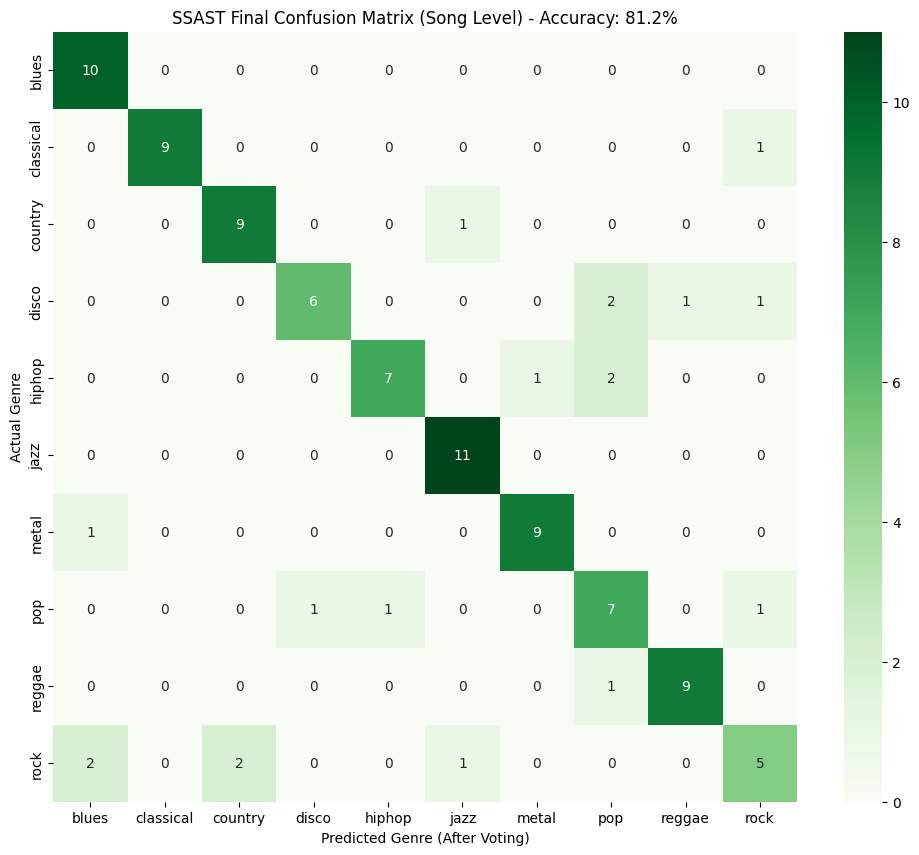

✅ Saved confusion_matrix_song_level.png


In [9]:
# Cell 11: Final Song-Level Confusion Matrix (The "Clean" One)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import numpy as np
import os
from collections import Counter

print("📊 Generating Song-Level Confusion Matrix...")

ssast_model.eval()
song_votes = {}
song_truth = {}
BATCH_SIZE = test_loader.batch_size

# 1. Collect all votes
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device)
        
        # Get predictions
        if device.type == 'cuda':
            with torch.amp.autocast('cuda'):
                logits = ssast_model(x, task='ft_avgtok')
        else:
            logits = ssast_model(x, task='ft_avgtok')
            
        _, preds = logits.max(1)
        preds = preds.cpu().numpy()
        labels = y.numpy()
        
        start_idx = i * BATCH_SIZE 
        for j in range(len(labels)):
            global_idx = start_idx + j
            row = test_ds.df.iloc[global_idx]
            filename = os.path.basename(row['filepath'])
            song_id = filename.rsplit('_', 1)[0]
            
            if song_id not in song_votes:
                song_votes[song_id] = []
                song_truth[song_id] = labels[j]
            
            song_votes[song_id].append(preds[j])

# 2. Apply Voting to get Final Labels
final_preds = []
final_truth = []

for song_id, votes in song_votes.items():
    # Hard Voting
    c = Counter(votes)
    winner, count = c.most_common(1)[0]
    
    final_preds.append(winner)
    final_truth.append(song_truth[song_id])

# 3. Plot
classes = test_ds.classes 
cm = confusion_matrix(final_truth, final_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual Genre')
plt.xlabel('Predicted Genre (After Voting)')
plt.title(f'SSAST Final Confusion Matrix (Song Level) - Accuracy: {100*np.mean(np.array(final_preds)==np.array(final_truth)):.1f}%')
plt.savefig("confusion_matrix_song_level.png")
plt.show()
print("✅ Saved confusion_matrix_song_level.png")

##### commands

In [6]:
import os
import shutil

def get_dir_size(path):
    total = 0
    try:
        for entry in os.scandir(path):
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir(follow_symlinks=False):
                total += get_dir_size(entry.path)
    except Exception:
        pass
    return total

def fmt(b):
    for u in ['B', 'K', 'M', 'G']:
        if b < 1024: return f"{b:.1f}{u}"
        b /= 1024
    return f"{b:.1f}T"

current = os.getcwd()
print(f"📍 Scanning relative to: {current}")

# 1. Check Current Folder
print(f"   Current Folder Size: {fmt(get_dir_size(current))}")

# 2. Check Parent Folder
parent = os.path.dirname(current)
print(f"\n📂 Scanning Parent: {parent}")
try:
    subdirs = []
    for entry in os.scandir(parent):
        if entry.is_dir():
            print(f"   > Measuring {entry.name}...")
            s = get_dir_size(entry.path)
            subdirs.append((entry.name, s))
    
    subdirs.sort(key=lambda x: x[1], reverse=True)
    print("\n🚨 BIGGEST FOLDERS IN PARENT:")
    for name, size in subdirs[:10]:
        print(f"   {fmt(size):<10} {name}")
except Exception as e:
    print(f"Error: {e}")

# 3. Check Trash specifically (Common culprit)
trash = os.path.expanduser("~/.local/share/Trash")
if os.path.exists(trash):
    print(f"\n🗑️ Trash Size: {fmt(get_dir_size(trash))}")
    print(f"   (Run 'import shutil; shutil.rmtree(\"{trash}\")' to empty it)")
else:
    print("\n✅ No Trash folder found.")

📍 Scanning relative to: /home/laughing_gates/workdir/SSAST-Project
   Current Folder Size: 4.2G

📂 Scanning Parent: /home/laughing_gates/workdir
   > Measuring streamlit...
   > Measuring SSAST-Project...
   > Measuring .ipynb_checkpoints...

🚨 BIGGEST FOLDERS IN PARENT:
   4.2G       SSAST-Project
   625.0B     streamlit
   0.0B       .ipynb_checkpoints

🗑️ Trash Size: 33.5G
   (Run 'import shutil; shutil.rmtree("/home/laughing_gates/.local/share/Trash")' to empty it)


In [27]:
import shutil
import os

# The path found by your scan
trash_path = "/home/laughing_gates/.local/share/Trash"

if os.path.exists(trash_path):
    print(f"🗑️ Emptying Trash at: {trash_path} ...")
    try:
        shutil.rmtree(trash_path)
        print("✅ Trash emptied! Disk space reclaimed.")
    except Exception as e:
        print(f"❌ Error emptying trash: {e}")
else:
    print("Trash is already empty.")

# Check space again
total, used, free = shutil.disk_usage(".")
print(f"💾 New Free Space: {free // (2**30)} GB")

🗑️ Emptying Trash at: /home/laughing_gates/.local/share/Trash ...
✅ Trash emptied! Disk space reclaimed.
💾 New Free Space: 32 GB
